In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np
from time import sleep
import os

from natsort import natsorted
from PIL import Image

from torch.autograd import Variable
from IPython.display import clear_output
from scipy import signal

In [2]:
device = 'cuda'

In [18]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [16]:
nc = 3
ch = 64

class GeneratorPicture(nn.Module):
    def __init__(self):
        super(GeneratorPicture, self).__init__()
        
        self.ConvLalyer1 = nn.Sequential(nn.Conv2d(in_channels=nc, out_channels=ch, kernel_size=4, stride=2, padding=1), #128
                                        nn.InstanceNorm2d(128*128),
                                        nn.ReLU())
        self.ConvLalyer2 = nn.Sequential(nn.Conv2d(in_channels=ch, out_channels=ch*2, kernel_size=4, stride=2, padding=1), #64
                                        nn.InstanceNorm2d(64*64),
                                        nn.ReLU())
        self.ConvLayer3 = nn.Sequential(nn.Conv2d(in_channels=ch*2, out_channels=ch*4, kernel_size=4, stride=2, padding=1), #32
                                        nn.InstanceNorm2d(32*32),
                                        nn.ReLU())
        self.ConvLayer4 = nn.Sequential(nn.Conv2d(in_channels=ch*4, out_channels=ch*8, kernel_size=4, stride=2, padding=1), #16
                                        nn.InstanceNorm2d(32*32),
                                        nn.ReLU())
        
        self.UpConvLayer1 = nn.Sequential(nn.ConvTranspose2d(in_channels=ch*8, out_channels=ch*4, kernel_size=2, stride=2),  #32
                                         nn.Dropout(p=0.1), 
                                         nn.ReLU())
        self.UpConvLayer2 = nn.Sequential(nn.ConvTranspose2d(in_channels=ch*8, out_channels=ch*2, kernel_size=2, stride=2), #64
                                         nn.Dropout(p=0.1),
                                         nn.ReLU())
        self.UpConvLayer3 = nn.Sequential(nn.ConvTranspose2d(in_channels=ch*4, out_channels=ch, kernel_size=2, stride=2), #128
                                         nn.Dropout(p=0.1),
                                         nn.ReLU())
        self.UpConvLayer4 = nn.Sequential(nn.ConvTranspose2d(in_channels=ch*2, out_channels=nc, kernel_size=2, stride=2), #256
                                         nn.Sigmoid())
        
    def forward(self, x):
        x1 = self.ConvLalyer1(x)
        x2 = self.ConvLalyer2(x1)
        x3 = self.ConvLayer3(x2)
        x4 = self.ConvLayer4(x3)
        
        #print(x1.shape)
        #print(x2.shape)
        #print(x3.shape)
        #print(x4.shape)
        
        output = self.UpConvLayer1(x4)
        output = self.UpConvLayer2(torch.cat((output, x3), axis=1))
        output = self.UpConvLayer3(torch.cat((output, x2), axis=1))
        output = self.UpConvLayer4(torch.cat((output, x1), axis=1))
        
        return output
        
        
generator_picture = GeneratorPicture().to(device)
print(generator_picture)        


GeneratorPicture(
  (ConvLalyer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(16384, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU()
  )
  (ConvLalyer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(4096, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU()
  )
  (ConvLayer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU()
  )
  (ConvLayer4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU()
  )
  (UpConvLayer1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))

In [24]:
nc = 3
ch = 64
class GeneratorPicture(nn.Module):
    def __init__(self):
        super(GeneratorPicture, self).__init__()
        self.double_conv_down1 = nn.Sequential(nn.ConvTranspose2d(in_channels=3, out_channels=ch, kernel_size=3, padding=1),
                                         nn.ReLU(),
                                         nn.ConvTranspose2d(in_channels=ch, out_channels=ch, kernel_size=3, padding=1),
                                         nn.ReLU())
        self.max_pool = nn.MaxPool2d(kernel_size=2)
        
        self.double_conv_down2 = nn.Sequential(nn.Conv2d(in_channels=ch, out_channels=ch*2, kernel_size=3, padding=1),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=ch*2, out_channels=ch*2, kernel_size=3, padding=1),
                                         nn.ReLU())
        
        self.double_conv_down3 = nn.Sequential(nn.Conv2d(in_channels=ch*2, out_channels=ch*4, kernel_size=3, padding=1),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=ch*4, out_channels=ch*4, kernel_size=3, padding=1),
                                         nn.ReLU())
        
        self.double_conv_down4 = nn.Sequential(nn.Conv2d(in_channels=ch*4, out_channels=ch*4, kernel_size=3, padding=1),
                                         nn.ReLU(),
                                         nn.ConvTranspose2d(in_channels=ch*4, out_channels=ch*4, kernel_size=3, padding=1),
                                         nn.ReLU())
        
        self.up_conv1 = nn.Sequential(nn.ConvTranspose2d(in_channels=ch*4, out_channels=ch*4, kernel_size=2, stride=2),
                                      nn.ReLU())
        
        self.double_conv_up1 = nn.Sequential(nn.Dropout2d(p=0.5),
                                            nn.Conv2d(in_channels=ch*8, out_channels=ch*2, kernel_size=3, padding=1),
                                            nn.ReLU(),
                                            nn.Conv2d(in_channels=ch*2, out_channels=ch*2, kernel_size=3, padding=1),
                                            nn.ReLU())
        
        self.up_conv2 = nn.Sequential(nn.ConvTranspose2d(in_channels=ch*2, out_channels=ch*2, kernel_size=2, stride=2),
                                     nn.ReLU())
        
        self.double_conv_up2 = nn.Sequential(nn.Dropout2d(p=0.5),
                                            nn.Conv2d(in_channels=ch*4, out_channels=ch, kernel_size=3, padding=1),
                                            nn.ReLU(),
                                            nn.Conv2d(in_channels=ch, out_channels=ch, kernel_size=3, padding=1),
                                            nn.ReLU())
        
        self.up_conv3 = nn.Sequential(nn.ConvTranspose2d(in_channels=ch, out_channels=ch, kernel_size=2, stride=2),
                                     nn.ReLU())
        
        self.double_conv_up3 = nn.Sequential(nn.Dropout2d(p=0.5),
                                            nn.Conv2d(in_channels=ch*2, out_channels=ch, kernel_size=3, padding=1),
                                            nn.ReLU(),
                                            nn.Conv2d(in_channels=ch, out_channels=ch, kernel_size=3, padding=1),
                                            nn.ReLU(),
                                            nn.Conv2d(in_channels=ch, out_channels=3, kernel_size=7, padding=3),
                                            nn.Sigmoid())
        
    def forward(self, x):
        x1 = self.double_conv_down1(x)
        x2 = self.double_conv_down2(self.max_pool(x1))
        x3 = self.double_conv_down3(self.max_pool(x2))
        
        x4 = self.double_conv_down4(self.max_pool(x3))
        
        print(x1.shape)
        print(x2.shape)
        print(x3.shape)
        print(x4.shape)

        out = self.up_conv1(x4)
        out = self.double_conv_up1(torch.cat((out, x3), axis=1))
        out = self.up_conv2(out)
        out = self.double_conv_up2(torch.cat((out, x2), axis=1))
        out = self.up_conv3(out)
        out = self.double_conv_up3(torch.cat((out, x1), axis=1))  
        
        return out
generator_picture = GeneratorPicture().to(device)
print(generator_picture)

GeneratorPicture(
  (double_conv_down1): Sequential(
    (0): ConvTranspose2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (double_conv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (double_conv_down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (double_conv_down4): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=

In [5]:
path_source = 'data/photo_jpg/'
path_clear = 'data/noise_clear/clear/'
path_noise = 'data/noise_clear/noise/'
for name in names:
    data = np.array(Image.open('data/photo_jpg/' + name))
    image1 = Image.fromarray(data)
    image1.save(path_clear + name)
    
    data[np.random.randint(60, size=(256, 256, 3)) == 0] = 0
    data[np.random.randint(60, size=(256, 256, 3)) == 0] = 255
    scharr = np.ones((4, 4)) * 1/16
    data[:, :, 0] = signal.convolve2d(data[:, :, 0], scharr, boundary='symm', mode='same')
    data[:, :, 1] = signal.convolve2d(data[:, :, 1], scharr, boundary='symm', mode='same')
    data[:, :, 2] = signal.convolve2d(data[:, :, 2], scharr, boundary='symm', mode='same')
    
    image2 = Image.fromarray(data)   
    image2.save(path_noise + name)

NameError: name 'names' is not defined

In [7]:
img = Image.open('data/noise_clear/noise/' + name)
plt.figure(figsize=(15, 15))
plt.imshow(img)

NameError: name 'name' is not defined

In [17]:
class DataSetNoise(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        self.total_imgs = os.listdir(os.path.join(main_dir , 'clear'))

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc_noise = os.path.join(self.main_dir, 'noise', self.total_imgs[idx])
        img_loc_clear = os.path.join(self.main_dir, 'clear', self.total_imgs[idx])
        
        image_noise = Image.open(img_loc_noise).convert('RGB')
        image_clear = Image.open(img_loc_clear).convert('RGB')
        
        tensor_image_noise = self.transform(image_noise)
        tensor_image_clear = self.transform(image_clear)
        
        return tensor_image_clear, tensor_image_noise

In [18]:
noise_dataset = DataSetNoise('data/noise_clear/', transform=torchvision.transforms.ToTensor())
noise_dataloader = DataLoader(noise_dataset, batch_size=16, shuffle=True, num_workers=4, drop_last=True)

In [19]:
optimizer = torch.optim.Adam(params=generator_picture.parameters(), lr=1e-4, betas=(0.5, 0.999))

In [14]:
lr = 8e-6
for param_group in optimizer.param_groups:
    param_group['lr'] = lr
    print(param_group['betas'])
    param_group['betas'] = (0.8, 0.999)

(0.8, 0.999)


Epoch:  1 / 90


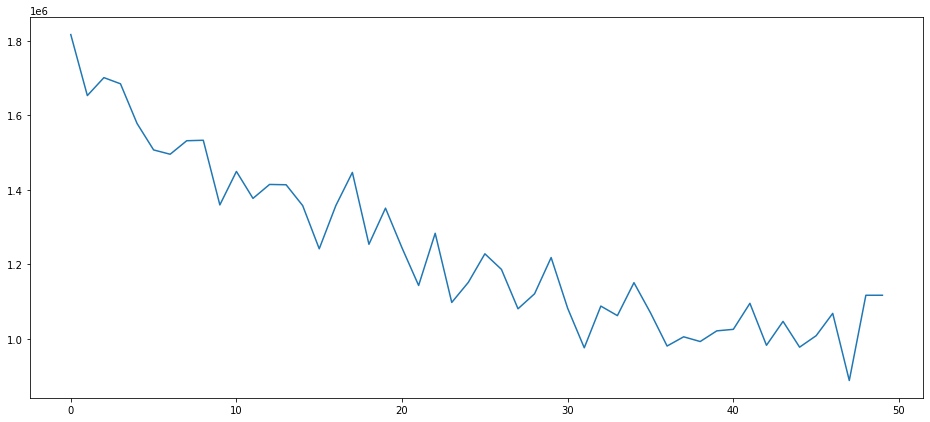

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


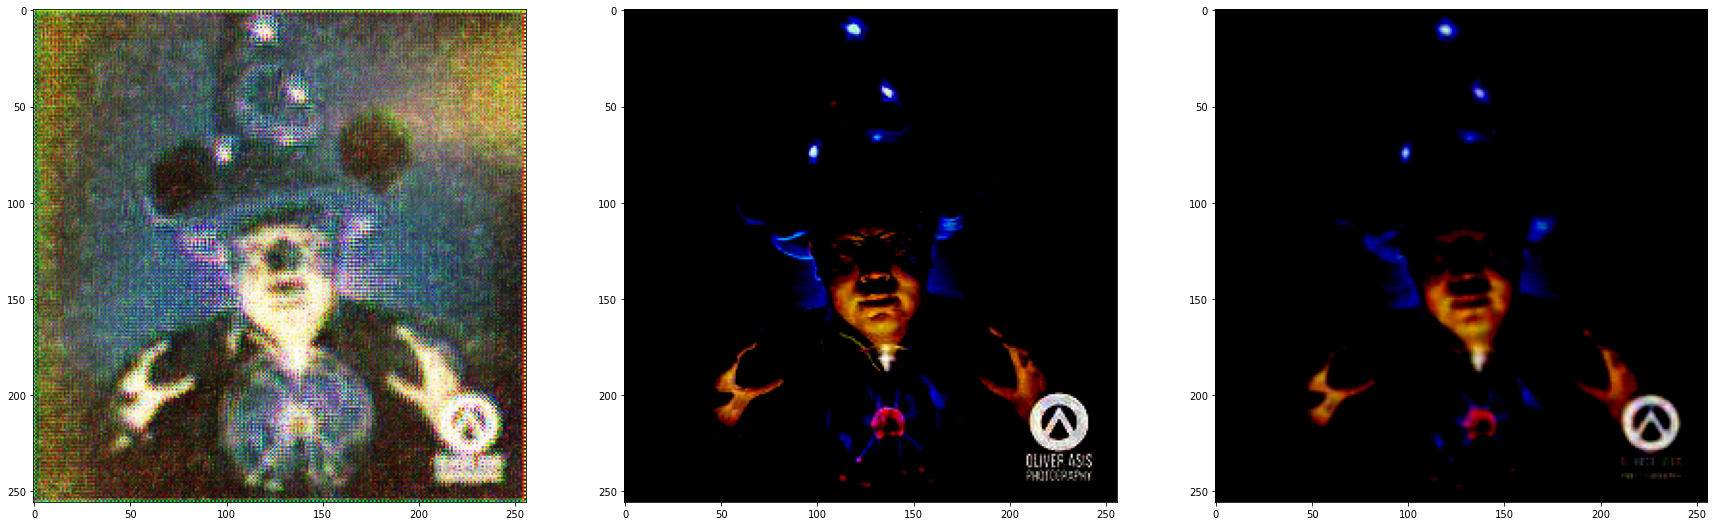

KeyboardInterrupt: 

In [20]:
losses = []
epochs = 90
for epoch in range(epochs):
    for data in noise_dataloader:
        clear, noise = data[0].to(device), data[1].to(device)
        clear, noise = 2*clear - 1, 2*noise - 1
        generator_picture.zero_grad()
        
        cleared = generator_picture(noise)
        
        loss = torch.sum(torch.abs(clear - cleared))
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        cleared = (1 + cleared)/2
    clear_output(True)
    print('Epoch: ', epoch, '/', epochs)
    plt.figure(figsize=(16, 7))
    plt.plot(losses)
    plt.show()
        
     
    
    plt.figure(figsize=(30, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(np.moveaxis(cleared[0].cpu().detach().numpy(), [0, 1, 2], [2, 0, 1]))
    plt.subplot(1, 3, 2)
    plt.imshow(np.moveaxis(clear[0].cpu().detach().numpy(), [0, 1, 2], [2, 0, 1]))
    plt.subplot(1, 3, 3)
    plt.imshow(np.moveaxis(noise[0].cpu().detach().numpy(), [0, 1, 2], [2, 0, 1]))
    plt.show()    
        
        
    
        

In [25]:
losses_np = np.array(losses)

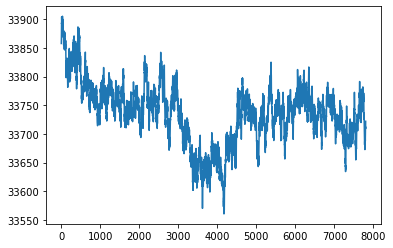

In [37]:
plt.plot(signal.convolve(losses_np, [1/1200 for i in range(1200)], mode='valid'))

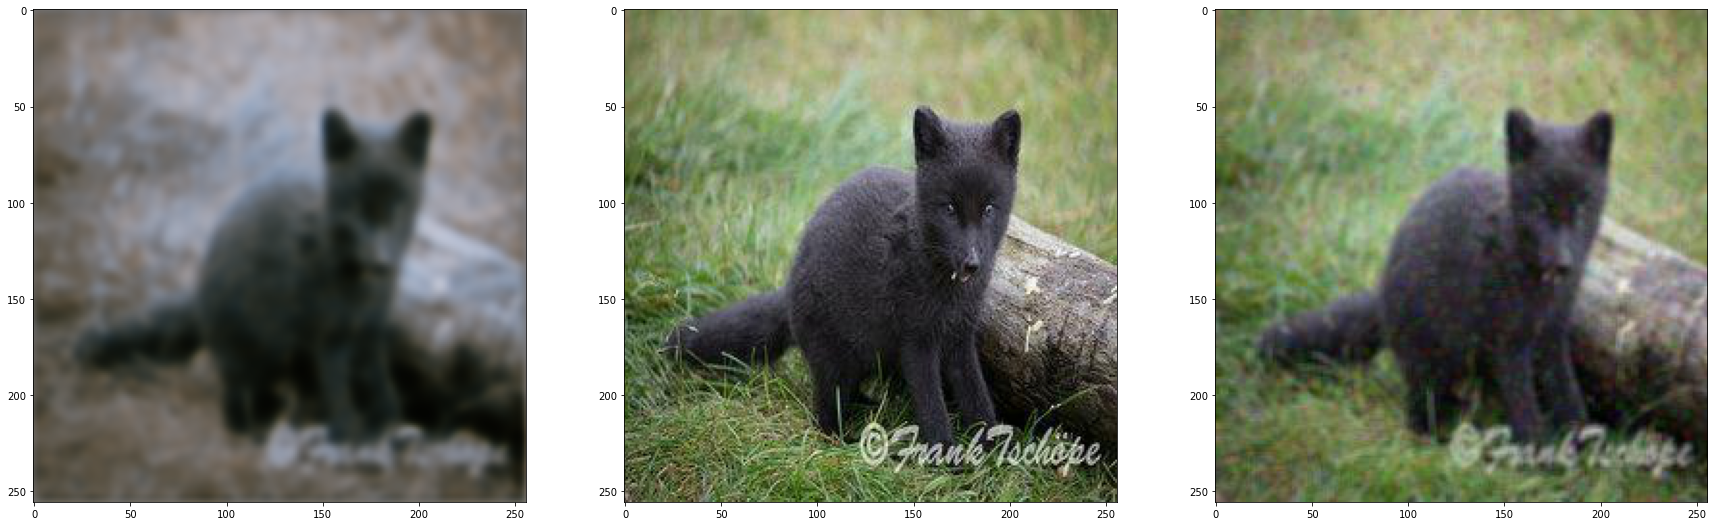

In [9]:
plt.figure(figsize=(30, 10))
plt.subplot(1, 3, 1)
plt.imshow(np.moveaxis(cleared[0].cpu().detach().numpy(), [0, 1, 2], [2, 0, 1]))
plt.subplot(1, 3, 2)
plt.imshow(np.moveaxis(clear[0].cpu().detach().numpy(), [0, 1, 2], [2, 0, 1]))
plt.subplot(1, 3, 3)
plt.imshow(np.moveaxis(noise[0].cpu().detach().numpy(), [0, 1, 2], [2, 0, 1]))